In [1]:
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
from anthropic import Anthropic
from jumpstart.src.consts import *

load_dotenv(override=True)
openai = OpenAI()
anthropic = Anthropic() 

In [2]:
import jumpstart.src.oracle
from jumpstart.src.oracle import generate_oracle_csv

# Regenerate the oracle CSV with automatic MTG data download and caching
print("🔄 Generating oracle CSV with automatic data download...")
generate_oracle_csv('pauper_cube_example_oracle.txt', 'output/oracle_output.csv')
print("✅ Oracle CSV generation complete!")

🔄 Generating oracle CSV with automatic data download...
Using cached cards data: .build/cards.csv
Oracle CSV generated: output/oracle_output.csv
✅ Oracle CSV generation complete!
Oracle CSV generated: output/oracle_output.csv
✅ Oracle CSV generation complete!


In [3]:
# Load the data files
oracle_df = pd.read_csv('output/oracle_output.csv')
print(f"Loaded {len(oracle_df)} cards from oracle_df")
print(f"Columns available: {list(oracle_df.columns)}")
oracle_df.head()

Loaded 450 cards from oracle_df
Columns available: ['name', 'CMC', 'Type', 'Color', 'Color Category', 'Oracle Text', 'tags', 'MTGO ID', 'Power', 'Toughness']


,name,CMC,Type,Color,Color Category,Oracle Text,tags,MTGO ID,Power,Toughness
0,Boros Elite,1,Creature — Human Soldier,W,White,Battalion — Whenever this creature and at leas...,NaN,NaN,1.0,1.0
1,Deftblade Elite,1,Creature — Human Soldier,W,White,"Provoke (Whenever this creature attacks, you m...",NaN,NaN,1.0,1.0
2,Doomed Traveler,1,Creature — Human Soldier,W,White,"When this creature dies, create a 1/1 white Sp...",NaN,NaN,1.0,1.0
3,Elite Vanguard,1,Creature — Human Soldier,W,White,NaN,NaN,NaN,2.0,1.0
4,Faerie Guidemother,1,Sorcery — Adventure,W,White,Target creature gets +2/+1 and gains flying un...,NaN,NaN,NaN,NaN


# Generate Themes

In [4]:
# Basic extraction with guild theme support
from jumpstart.src.theme_extraction.extractor import ThemeExtractor
from jumpstart.src.theme_extraction.utils import generate_theme_code


extractor = ThemeExtractor(oracle_df)
# Now includes guild themes by default!
all_themes = extractor.extract_themes(min_cards_per_theme=10, include_guilds=True)
print(extractor.generate_theme_summary(all_themes))

generated_themes = extractor.select_optimal_themes(
    themes=all_themes, 
    mono_count=20, 
    dual_count=10, 
    prioritize_buildability=True, 
    diversity_weight=0.7
)

# Extracted Themes Summary

## Tribal Themes (4)
- **Black Tribals** (B): Zombie tribal with synergistic effects and creature bonuses
- **Blue Tribals** (U): Wizard tribal with synergistic effects and creature bonuses
- **Red Tribals** (R): Warrior tribal with synergistic effects and creature bonuses
- **White Tribals** (W): Soldier tribal with synergistic effects and creature bonuses

## Equipment Themes (3)
- **Black Equipment** (B): Equipment strategy with equipment gameplan
- **Red Equipment** (R): Equipment strategy with equipment gameplan
- **White Equipment** (W): Equipment strategy with equipment gameplan

## Aggro Themes (12)
- **Black Aggro** (B): Aggro strategy with aggro gameplan
- **Black Fast** (B): Fast aggressive deck with efficient low-cost threats
- **Blue Fast** (U): Fast aggressive deck with efficient low-cost threats
- **Boros Aggro** (R + W): Boros guild synergies with aggro gameplan
- **Green Aggro** (G): Aggro strategy with aggro gameplan
- **Green Fast** (G): F

# Deck Construction
Now let's test the deck construction function to build actual jumpstart decks from our themes.

In [5]:
# Test the refactored deck construction function

# Build all jumpstart decks using the new refactored version
from jumpstart.src.construct import construct_jumpstart_decks, print_detailed_deck_analysis, CardConstraints, analyze_deck_composition

# Create constraints with custom target deck size and non-land limits
constraints = CardConstraints(
    target_deck_size=13,
    max_lands_dual=1,
    max_lands_mono=1,
    total_non_land=12,  # All 12 cards should be non-lands
    min_creatures=2,  # Set minimum to 4 for testing
    max_creatures=9
)

print("🚀 Starting deck construction with refactored algorithm...")
# deck_dataframes = construct_jumpstart_decks(oracle_df, constraints=constraints, themes=ALL_THEMES)
deck_dataframes = construct_jumpstart_decks(oracle_df, constraints=constraints, themes=generated_themes)

# Generate analysis first, then print detailed analysis
analysis = analyze_deck_composition(deck_dataframes)
print_detailed_deck_analysis(deck_dataframes, analysis, constraints)

🚀 Starting deck construction with refactored algorithm...
🏗️ CONSTRUCTING JUMPSTART DECKS

🔒 Phase 0: Core card reservation
Ensuring each theme gets its defining cards before general competition...

🎯 White Enchantments: Reserving core cards
  ✅ Glimmerlight              |   3.5 pts | Artifact — Equipment
  ✅ Mandibular Kite           |   3.0 pts | Artifact — Equipment
  ✅ Cartouche of Solidarity   |   3.0 pts | Enchantment — Aura C...
  📦 Reserved 3 core cards

🎯 White Slivers: Reserving core cards
  ✅ Deftblade Elite           |   1.0 pts | Creature — Human Sol...
  ✅ Faerie Guidemother        |   1.0 pts | Sorcery — Adventure
  ✅ Seeker of the Way         |   1.0 pts | Creature — Human War...
  📦 Reserved 3 core cards

🎯 White Tribals: Reserving core cards
  ✅ Ancestral Blade           |   6.0 pts | Artifact — Equipment
  ✅ Boros Elite               |   5.3 pts | Creature — Human Sol...
  ✅ Aerie Auxiliary           |   5.3 pts | Creature — Bird Sold...
  ✅ Eagles of the North      

In [6]:
from jumpstart.src.export import export_cube_to_csv


export_cube_to_csv(deck_dataframes, 'output/generated_jumpstart_decks.csv', oracle_df)

Exporting jumpstart cube to output/generated_jumpstart_decks.csv...
Adding 60 unassigned cards...
✅ Successfully exported 450 cards to output/generated_jumpstart_decks.csv

📊 Export Summary:
Total cards: 450
Assigned cards: 390
Unassigned cards: 60
Number of decks: 30

Deck breakdown:
  Red Burn: 13 cards
  White Enchantments: 13 cards
  Simic Ramp: 13 cards
  Green Voltron: 13 cards
  White Voltron: 13 cards
  Dimir Control: 13 cards
  Black Tempo: 13 cards
  Gruul Aggro: 13 cards
  Red Aggro: 13 cards
  Blue Mill: 13 cards
  Unassigned: 60 cards
  ... and 20 more decks


'output/generated_jumpstart_decks.csv'

In [7]:
# Import validation functions and run card uniqueness validation
from jumpstart.src.validation import validate_card_uniqueness, validate_deck_constraints, validate_jumpstart_cube, display_validation_summary

# Run the validation
# validation_result = validate_card_uniqueness(deck_dataframes)
validate_jumpstart_cube(deck_dataframes, oracle_df, ALL_THEMES, constraints)

🎯 COMPREHENSIVE JUMPSTART CUBE VALIDATION
🔍 VALIDATING CARD UNIQUENESS
📊 VALIDATION RESULTS:
Total cards across all decks: 390
Unique cards used: 390
Duplicate cards found: 0

✅ VALIDATION PASSED!
All 390 cards are used exactly once.
🔍 VALIDATING DECK CONSTRAINTS
📊 CONSTRAINT VALIDATION RESULTS:
Valid decks: 30/30
Constraint violations: 0

✅ ALL CONSTRAINTS SATISFIED!

📈 CARD DISTRIBUTION ANALYSIS
📊 OVERALL STATISTICS:
Total cards available: 450
Total cards used: 390
Cards unused: 60
Usage rate: 86.7%

🎨 USAGE BY COLOR:
  White    :  68/ 70 cards ( 97.1%)
  Blue     :  61/ 67 cards ( 91.0%)
  Black    :  56/ 67 cards ( 83.6%)
  Red      :  61/ 67 cards ( 91.0%)
  Green    :  61/ 67 cards ( 91.0%)
  Colorless:  51/ 74 cards ( 68.9%)

🎯 DECK COMPLETENESS:
Complete decks (13 cards): 30
Incomplete decks: 0

📋 UNUSED CARDS ANALYSIS:
Unused creatures: 17
Unused lands: 23
Unused spells: 20

Sample unused cards:
  • Alabaster Host Intercessor (Creature — Phyrexian Samurai) - W
  • Warden of Ev

{'overall_valid': True,
 'uniqueness': {'valid': True,
  'total_cards': 390,
  'unique_cards': 390,
  'duplicates': {},
  'duplicate_count': 0,
  'extra_instances': 0},
 'constraints': {'valid': True,
  'valid_decks': 30,
  'total_decks': 30,
  'violations': []},
 'distribution': {'total_available': 450,
  'total_used': 390,
  'unused_count': 60,
  'usage_rate': 0.8666666666666667,
  'color_stats': {'W': {'used': 68,
    'available': 70,
    'rate': 97.14285714285714},
   'U': {'used': 61, 'available': 67, 'rate': 91.04477611940298},
   'B': {'used': 56, 'available': 67, 'rate': 83.5820895522388},
   'R': {'used': 61, 'available': 67, 'rate': 91.04477611940298},
   'G': {'used': 61, 'available': 67, 'rate': 91.04477611940298},
   'C': {'used': 51, 'available': 74, 'rate': 68.91891891891892}},
  'complete_decks': 30,
  'incomplete_decks': []}}

In [8]:
# Additional analysis using the imported validation functions
from jumpstart.src.validation import analyze_card_distribution

# Run the distribution analysis
distribution_analysis = analyze_card_distribution(deck_dataframes, oracle_df, constraints)


📈 CARD DISTRIBUTION ANALYSIS
📊 OVERALL STATISTICS:
Total cards available: 450
Total cards used: 390
Cards unused: 60
Usage rate: 86.7%

🎨 USAGE BY COLOR:
  White    :  68/ 70 cards ( 97.1%)
  Blue     :  61/ 67 cards ( 91.0%)
  Black    :  56/ 67 cards ( 83.6%)
  Red      :  61/ 67 cards ( 91.0%)
  Green    :  61/ 67 cards ( 91.0%)
  Colorless:  51/ 74 cards ( 68.9%)

🎯 DECK COMPLETENESS:
Complete decks (13 cards): 30
Incomplete decks: 0

📋 UNUSED CARDS ANALYSIS:
Unused creatures: 17
Unused lands: 23
Unused spells: 20

Sample unused cards:
  • Alabaster Host Intercessor (Creature — Phyrexian Samurai) - W
  • Warden of Evos Isle (Creature — Bird Wizard) - U
  • Bubble Snare (Enchantment — Aura) - U
  • Unable to Scream (Enchantment — Aura) - U
  • Weakstone's Subjugation (Enchantment — Aura) - U
  • Witness Protection (Enchantment — Aura) - U
  • Okiba-Gang Shinobi (Creature — Rat Ninja) - B
  • Vampire Sovereign (Creature — Vampire Noble) - B
  • Troll of Khazad-dûm (Creature — Troll)

In [9]:
# Compute metrics for all decks\n
from jumpstart.src.balance import compute_all_deck_metrics
metrics_df = compute_all_deck_metrics(deck_dataframes, ALL_THEMES)
metrics_df.set_index('theme', inplace=True)
metrics_df.head()


,avg_cmc,keyword_density,archetype_alignment,card_quality,synergy,deck_size,type_artifact,type_equipment,type_enchantment,type_aura,...,type_toy,type_bat,type_thrull,type_wolverine,type_hag,type_leech,type_detective,type_citizen,type_mutant,type_turtle
theme,,,,,,,,,,,,,,,,,,,,,
White Enchantments,2.000000,0.0,0.0,1.307692,0.0,13,0.064516,0.064516,0.161290,0.16129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Slivers,1.769231,0.0,0.0,2.307692,0.0,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Tribals,2.923077,0.0,0.0,3.076923,0.0,13,0.029412,0.029412,0.029412,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Voltron,2.461538,0.0,0.0,2.538462,0.0,13,0.093750,0.093750,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blue Tribals,2.923077,0.0,0.0,2.307692,0.0,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


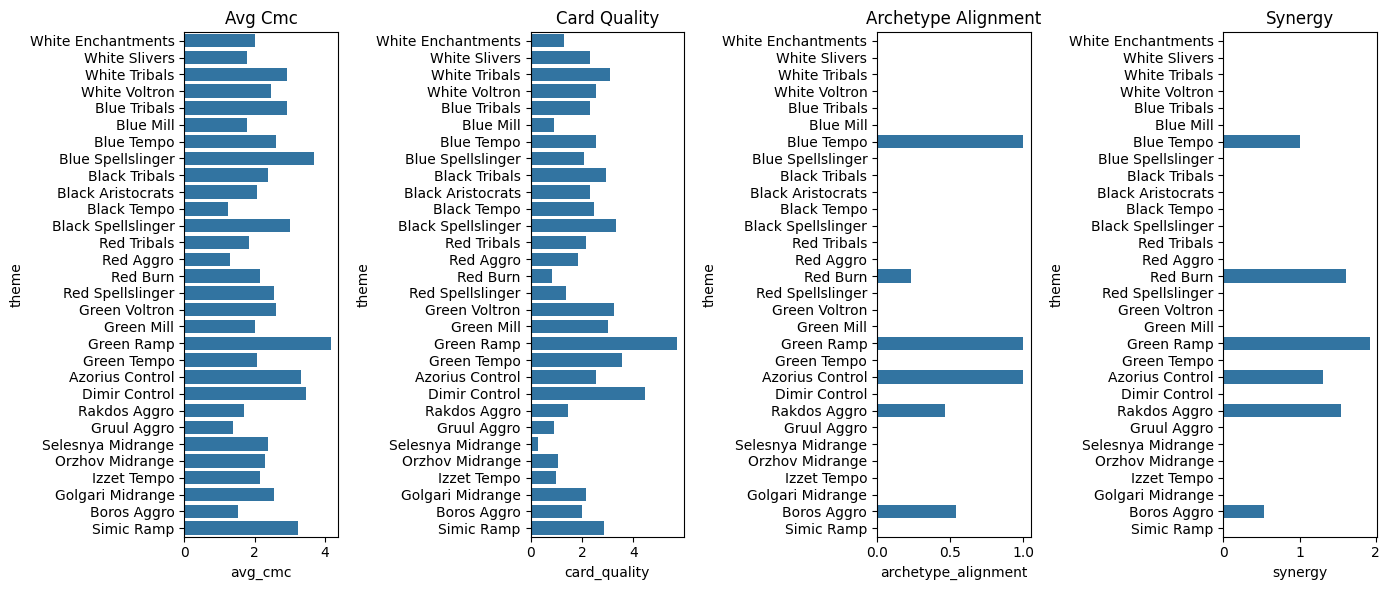

In [10]:
# Bar plots for key metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['avg_cmc', 'card_quality', 'archetype_alignment', 'synergy']):
    plt.subplot(1, 4, i+1)
    sns.barplot(y=metrics_df.index, x=metrics_df[metric], orient='h')
    plt.title(metric.replace('_', ' ').title())
    plt.tight_layout()
plt.show()

In [11]:
# Import plotly for interactive visualizations
import plotly.graph_objects as go

sample_themes = metrics_df.index[:]  # Show first 5 decks as example
radar_metrics = ['avg_cmc', 'card_quality', 'archetype_alignment', 'synergy', 'keyword_density']
fig = go.Figure()
for theme in sample_themes:
    values = metrics_df.loc[theme, radar_metrics].values.tolist()
    fig.add_trace(go.Scatterpolar(
        r=values + [values[0]],
        theta=radar_metrics + [radar_metrics[0]],
        fill='toself',
        name=theme
    ))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title='Deck Balance Radar Chart (Sample)'
)
fig.show()

# CMC Curve Analysis
Let's visualize the Converted Mana Cost (CMC) curves for each deck to understand their mana distribution and speed.

In [12]:
# Calculate CMC curves for all decks
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

def calculate_cmc_curve(deck_df):
    """Calculate the CMC distribution for a deck."""
    # Only count non-land cards for CMC curve
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    cmc_counts = Counter(non_lands['CMC'])
    
    # Create a full range from 0 to max CMC
    max_cmc = max(cmc_counts.keys()) if cmc_counts else 0
    cmc_curve = [cmc_counts.get(i, 0) for i in range(max_cmc + 1)]
    
    return cmc_curve, non_lands

# Calculate CMC curves for all decks
cmc_data = {}
deck_stats = {}

for theme_name, deck_df in deck_dataframes.items():
    cmc_curve, non_lands = calculate_cmc_curve(deck_df)
    cmc_data[theme_name] = cmc_curve
    deck_stats[theme_name] = {
        'avg_cmc': non_lands['CMC'].mean() if len(non_lands) > 0 else 0,
        'total_cards': len(deck_df),
        'non_lands': len(non_lands),
        'lands': len(deck_df) - len(non_lands)
    }

print("CMC curve data calculated for all decks!")
print(f"Sample stats for first deck ({list(deck_stats.keys())[0]}):")
first_deck = list(deck_stats.keys())[0]
print(f"  Average CMC: {deck_stats[first_deck]['avg_cmc']:.2f}")
print(f"  Total cards: {deck_stats[first_deck]['total_cards']}")
print(f"  Non-land cards: {deck_stats[first_deck]['non_lands']}")
print(f"  Lands: {deck_stats[first_deck]['lands']}")

CMC curve data calculated for all decks!
Sample stats for first deck (White Enchantments):
  Average CMC: 2.17
  Total cards: 13
  Non-land cards: 12
  Lands: 1


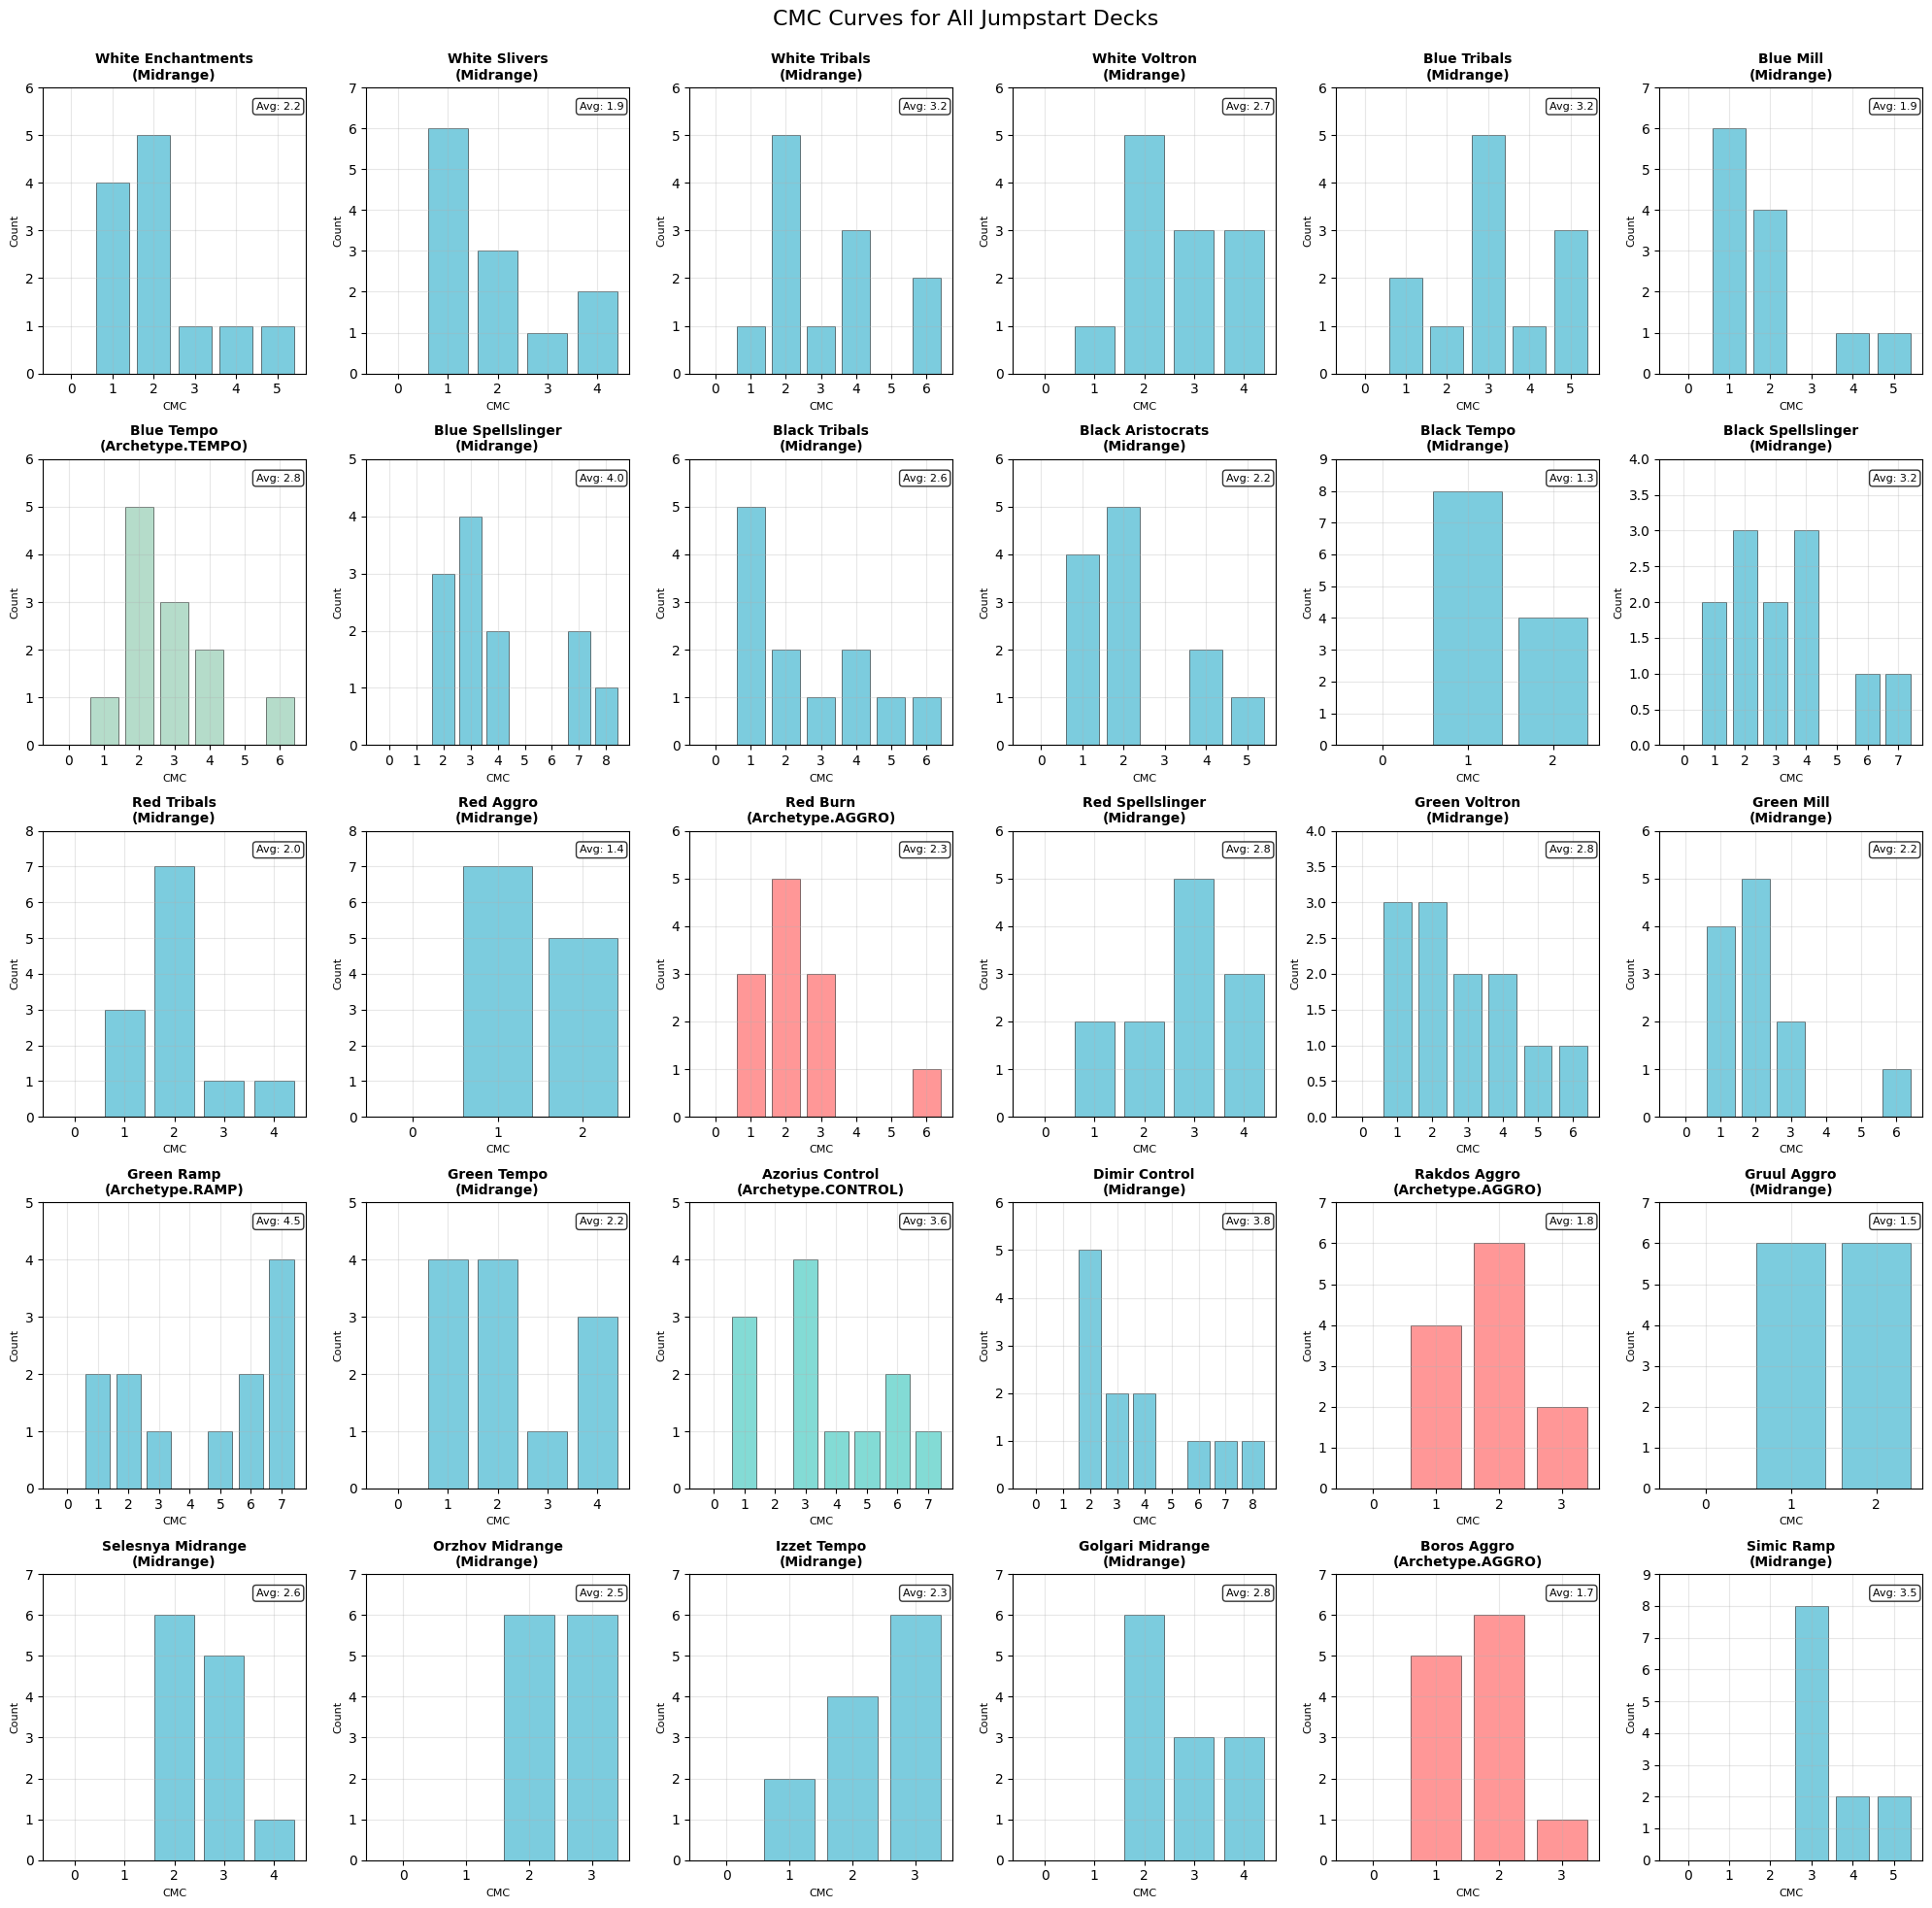

✅ CMC curves plotted for all 30 decks!
Color legend:
  Aggro: #FF6B6B
  Control: #4ECDC4
  Midrange: #45B7D1
  Tempo: #96CEB4
  Combo: #FFEAA7


In [13]:
# Create a large grid plot showing CMC curves for all decks
plt.style.use('default')
num_decks = len(deck_dataframes)
cols = 6  # 6 columns
rows = (num_decks + cols - 1) // cols  # Calculate needed rows

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
fig.suptitle('CMC Curves for All Jumpstart Decks', fontsize=16, y=0.98)

# Flatten axes for easy iteration
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

# Color scheme for different archetypes
archetype_colors = {
    'Aggro': '#FF6B6B',
    'Control': '#4ECDC4', 
    'Midrange': '#45B7D1',
    'Tempo': '#96CEB4',
    'Combo': '#FFEAA7'
}

for i, (theme_name, deck_df) in enumerate(deck_dataframes.items()):
    ax = axes[i]
    
    # Get CMC curve and deck info
    cmc_curve, non_lands = calculate_cmc_curve(deck_df)
    
    # Determine archetype for coloring
    archetype = 'Midrange'  # Default
    if theme_name in ALL_THEMES:
        archetype = ALL_THEMES[theme_name].get('archetype', 'Midrange')
    
    color = archetype_colors.get(archetype, '#45B7D1')
    
    # Plot the CMC curve
    x_values = list(range(len(cmc_curve)))
    ax.bar(x_values, cmc_curve, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Customize each subplot
    ax.set_title(f'{theme_name}\n({archetype})', fontsize=10, fontweight='bold')
    ax.set_xlabel('CMC', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.set_xticks(x_values)
    ax.grid(True, alpha=0.3)
    
    # Add average CMC as text
    avg_cmc = non_lands['CMC'].mean() if len(non_lands) > 0 else 0
    ax.text(0.98, 0.95, f'Avg: {avg_cmc:.1f}', transform=ax.transAxes, 
            ha='right', va='top', fontsize=8, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Set consistent y-axis limits
    ax.set_ylim(0, max(max(cmc_curve), 1) + 1)

# Hide empty subplots
for i in range(num_decks, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

print(f"✅ CMC curves plotted for all {num_decks} decks!")
print("Color legend:")
for archetype, color in archetype_colors.items():
    print(f"  {archetype}: {color}")

In [14]:
# Summary statistics and comparison plots
print("📊 CMC CURVE SUMMARY STATISTICS")
print("="*50)

# Create a DataFrame with CMC statistics
cmc_summary = []
for theme_name, stats in deck_stats.items():
    archetype = ALL_THEMES.get(theme_name, {}).get('archetype', 'Midrange')
    # Convert enum to string for DataFrame compatibility
    if hasattr(archetype, 'value'):
        archetype = archetype.value
    
    cmc_summary.append({
        'Theme': theme_name,
        'Archetype': archetype,
        'Avg_CMC': stats['avg_cmc'],
        'Total_Cards': stats['total_cards'],
        'Non_Lands': stats['non_lands'],
        'Lands': stats['lands']
    })

cmc_summary_df = pd.DataFrame(cmc_summary)
cmc_summary_df = cmc_summary_df.sort_values('Avg_CMC')

print("Top 5 Fastest Decks (Lowest Average CMC):")
print(cmc_summary_df.head()[['Theme', 'Archetype', 'Avg_CMC']].to_string(index=False))

print("\nTop 5 Slowest Decks (Highest Average CMC):")
print(cmc_summary_df.tail()[['Theme', 'Archetype', 'Avg_CMC']].to_string(index=False))

print(f"\nOverall Statistics:")
print(f"Average CMC across all decks: {cmc_summary_df['Avg_CMC'].mean():.2f}")
print(f"CMC Standard Deviation: {cmc_summary_df['Avg_CMC'].std():.2f}")
print(f"Fastest deck: {cmc_summary_df.iloc[0]['Theme']} ({cmc_summary_df.iloc[0]['Avg_CMC']:.2f})")
print(f"Slowest deck: {cmc_summary_df.iloc[-1]['Theme']} ({cmc_summary_df.iloc[-1]['Avg_CMC']:.2f})")

📊 CMC CURVE SUMMARY STATISTICS
Top 5 Fastest Decks (Lowest Average CMC):
       Theme Archetype  Avg_CMC
 Black Tempo  Midrange 1.333333
   Red Aggro  Midrange 1.416667
 Gruul Aggro  Midrange 1.500000
 Boros Aggro     Aggro 1.666667
Rakdos Aggro     Aggro 1.833333

Top 5 Slowest Decks (Highest Average CMC):
            Theme Archetype  Avg_CMC
       Simic Ramp  Midrange 3.500000
  Azorius Control   Control 3.583333
    Dimir Control  Midrange 3.750000
Blue Spellslinger  Midrange 4.000000
       Green Ramp      Ramp 4.500000

Overall Statistics:
Average CMC across all decks: 2.58
CMC Standard Deviation: 0.78
Fastest deck: Black Tempo (1.33)
Slowest deck: Green Ramp (4.50)


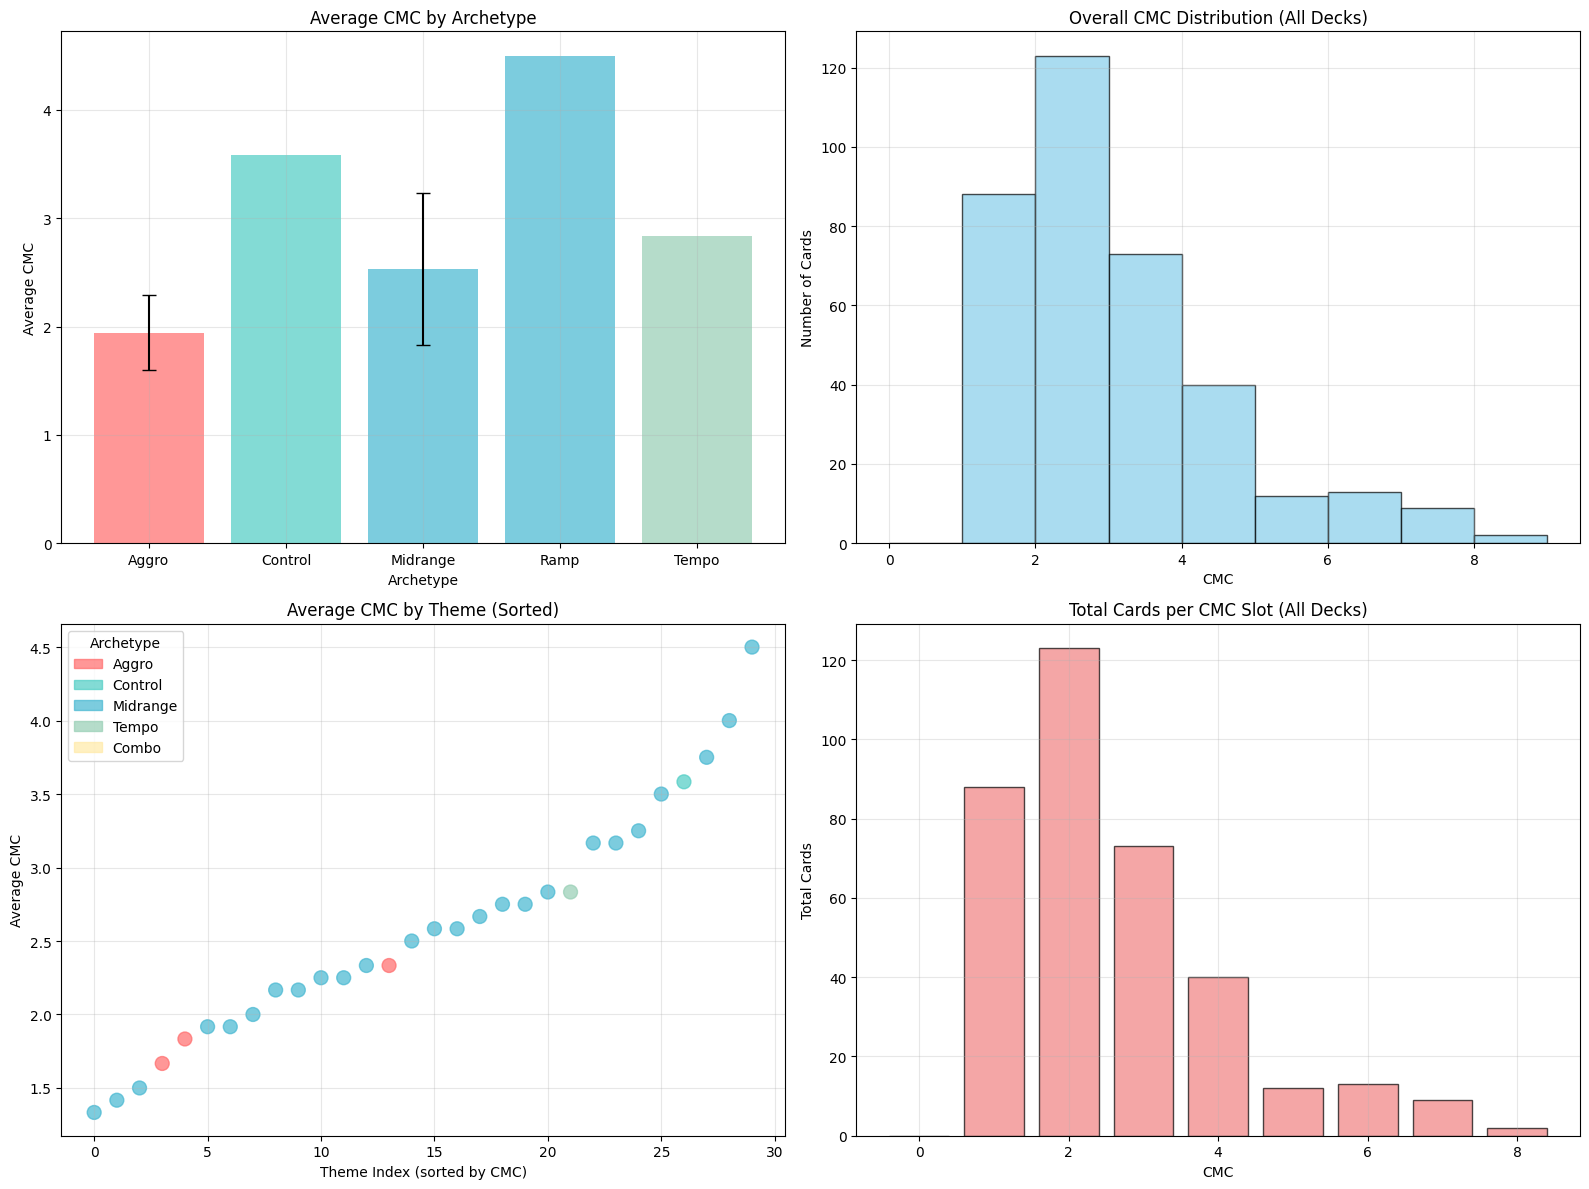

✅ CMC analysis complete! The visualizations show:
  📈 Individual deck curves with archetype coloring
  📊 Statistical summaries and comparisons
  🎯 Archetype-based CMC patterns
  📋 Overall cube CMC distribution


In [15]:
# Archetype comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Convert archetype enums to strings for plotting compatibility
cmc_summary_df_plot = cmc_summary_df.copy()
cmc_summary_df_plot['Archetype'] = cmc_summary_df_plot['Archetype'].apply(
    lambda x: x.value if hasattr(x, 'value') else str(x)
)

# 1. Average CMC by Archetype
archetype_cmc = cmc_summary_df_plot.groupby('Archetype')['Avg_CMC'].agg(['mean', 'std', 'count'])
ax1.bar(archetype_cmc.index, archetype_cmc['mean'], 
        yerr=archetype_cmc['std'], capsize=5, alpha=0.7,
        color=[archetype_colors.get(arch, '#45B7D1') for arch in archetype_cmc.index])
ax1.set_title('Average CMC by Archetype')
ax1.set_ylabel('Average CMC')
ax1.set_xlabel('Archetype')
ax1.grid(True, alpha=0.3)

# 2. CMC Distribution (all decks combined)
all_cmcs = []
for theme_name, deck_df in deck_dataframes.items():
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    all_cmcs.extend(non_lands['CMC'].tolist())

ax2.hist(all_cmcs, bins=range(max(all_cmcs) + 2), alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_title('Overall CMC Distribution (All Decks)')
ax2.set_xlabel('CMC')
ax2.set_ylabel('Number of Cards')
ax2.grid(True, alpha=0.3)

# 3. Average CMC scatter plot by theme
colors = []
for theme in cmc_summary_df_plot['Theme']:
    archetype = ALL_THEMES.get(theme, {}).get('archetype', 'Midrange')
    # Convert enum to string for color lookup
    if hasattr(archetype, 'value'):
        archetype = archetype.value
    colors.append(archetype_colors.get(archetype, '#45B7D1'))

ax3.scatter(range(len(cmc_summary_df_plot)), cmc_summary_df_plot['Avg_CMC'], 
           c=colors, alpha=0.7, s=100)
ax3.set_title('Average CMC by Theme (Sorted)')
ax3.set_xlabel('Theme Index (sorted by CMC)')
ax3.set_ylabel('Average CMC')
ax3.grid(True, alpha=0.3)

# Add archetype legend
handles = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7) 
           for archetype, color in archetype_colors.items()]
labels = list(archetype_colors.keys())
ax3.legend(handles, labels, title='Archetype', loc='upper left')

# 4. Cards per CMC slot comparison
cmc_slots = {}
max_cmc = max(all_cmcs)
for cmc in range(max_cmc + 1):
    cmc_slots[cmc] = sum(1 for c in all_cmcs if c == cmc)

ax4.bar(cmc_slots.keys(), cmc_slots.values(), alpha=0.7, color='lightcoral', edgecolor='black')
ax4.set_title('Total Cards per CMC Slot (All Decks)')
ax4.set_xlabel('CMC')
ax4.set_ylabel('Total Cards')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ CMC analysis complete! The visualizations show:")
print("  📈 Individual deck curves with archetype coloring")
print("  📊 Statistical summaries and comparisons")
print("  🎯 Archetype-based CMC patterns")
print("  📋 Overall cube CMC distribution")

# Comprehensive Deck Performance Analysis

Now let's analyze how well each deck will perform across multiple dimensions. This analysis will help identify the strongest and weakest decks, and suggest improvements.

## Performance Metrics We'll Analyze:
1. **Speed & Consistency** - How fast and reliable the deck is
2. **Card Quality** - Overall power level of individual cards
3. **Synergy Score** - How well cards work together
4. **Threat Density** - Proportion of impactful cards
5. **Interaction Quality** - Removal and answers available
6. **Mana Efficiency** - How well the deck uses its mana
7. **Late Game Power** - Performance in longer games
8. **Archetype Coherence** - How well the deck follows its intended strategy

In [16]:
def calculate_deck_performance_metrics(deck_df, theme_name, oracle_df):
    """
    Calculate comprehensive performance metrics for a single deck.
    """
    metrics = {}
    
    # Basic deck info
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    creatures = deck_df[deck_df['Type'].str.contains('Creature', na=False)]
    
    # 1. Speed & Consistency Metrics
    avg_cmc = non_lands['CMC'].mean() if len(non_lands) > 0 else 0
    cmc_variance = non_lands['CMC'].var() if len(non_lands) > 1 else 0
    early_game_cards = len(non_lands[non_lands['CMC'] <= 2])
    
    metrics['speed_score'] = max(0, 5 - avg_cmc)  # Lower CMC = higher speed
    metrics['consistency_score'] = max(0, 5 - cmc_variance)  # Lower variance = more consistent
    metrics['early_game_density'] = early_game_cards / len(non_lands) if len(non_lands) > 0 else 0
    
    # 2. Card Quality Assessment
    # Use existing quality scores if available, otherwise estimate
    if 'card_quality' in deck_df.columns:
        avg_quality = deck_df['card_quality'].mean()
    else:
        # Estimate quality based on rarity and CMC efficiency
        quality_scores = []
        for _, card in deck_df.iterrows():
            if 'Rarity' in card:
                rarity_score = {'C': 1, 'U': 2, 'R': 3, 'M': 4}.get(card['Rarity'], 1)
            else:
                rarity_score = 2  # Default
            
            # Higher CMC should provide more value
            cmc_efficiency = min(card['CMC'] / 3, 2) if card['CMC'] > 0 else 1
            quality_scores.append(rarity_score * cmc_efficiency)
        
        avg_quality = sum(quality_scores) / len(quality_scores) if quality_scores else 2
    
    metrics['card_quality'] = min(avg_quality, 5)  # Cap at 5
    
    # 3. Threat Density
    # Count cards that can win the game
    win_conditions = 0
    for _, card in deck_df.iterrows():
        # Creatures with power >= 3, or planeswalkers, or key spells
        if 'Creature' in str(card['Type']) and 'Power' in card:
            try:
                power = int(str(card['Power']).replace('*', '0'))
                if power >= 3:
                    win_conditions += 1
            except:
                win_conditions += 0.5  # Partial credit for unknown power
        elif any(cardtype in str(card['Type']) for cardtype in ['Planeswalker', 'Enchantment']):
            win_conditions += 0.5
    
    metrics['threat_density'] = min(win_conditions / len(non_lands), 1) if len(non_lands) > 0 else 0
    
    # 4. Interaction Quality
    interaction_keywords = ['destroy', 'exile', 'counter', 'return', 'damage', 'fight', 'bounce']
    interaction_count = 0
    
    for _, card in deck_df.iterrows():
        text = str(card.get('Text', '') or '').lower()
        if any(keyword in text for keyword in interaction_keywords):
            interaction_count += 1
    
    metrics['interaction_score'] = min(interaction_count / len(non_lands), 0.5) if len(non_lands) > 0 else 0
    
    # 5. Mana Efficiency
    total_mana_value = non_lands['CMC'].sum()
    expected_mana = len(non_lands) * 2.5  # Expected average CMC
    metrics['mana_efficiency'] = min(expected_mana / max(total_mana_value, 1), 2)
    
    # 6. Late Game Power
    expensive_cards = len(non_lands[non_lands['CMC'] >= 5])
    metrics['late_game_power'] = min(expensive_cards / max(len(non_lands), 1), 0.4)
    
    # 7. Creature Quality (for creature-based strategies)
    creature_ratio = len(creatures) / len(non_lands) if len(non_lands) > 0 else 0
    avg_creature_cmc = creatures['CMC'].mean() if len(creatures) > 0 else 0
    
    metrics['creature_quality'] = creature_ratio * min(avg_creature_cmc / 3, 1.5)
    
    # 8. Archetype Coherence
    if theme_name in ALL_THEMES:
        expected_archetype = ALL_THEMES[theme_name].get('archetype', 'Midrange')
        
        # Convert enum to string for comparison
        if hasattr(expected_archetype, 'value'):
            expected_archetype = expected_archetype.value
        
        # Score based on how well the deck matches its archetype
        if expected_archetype == 'Aggro':
            coherence = metrics['speed_score'] / 5 * 0.4 + metrics['early_game_density'] * 0.6
        elif expected_archetype == 'Control':
            coherence = metrics['interaction_score'] / 0.5 * 0.5 + metrics['late_game_power'] / 0.4 * 0.5
        elif expected_archetype == 'Combo':
            coherence = metrics['consistency_score'] / 5 * 0.7 + metrics['mana_efficiency'] / 2 * 0.3
        else:  # Midrange/Tempo
            coherence = (metrics['creature_quality'] + metrics['interaction_score'] / 0.5) / 2
        
        metrics['archetype_coherence'] = min(coherence, 1)
    else:
        metrics['archetype_coherence'] = 0.5  # Default
    
    # Overall Performance Score (weighted average)
    weights = {
        'speed_score': 0.15,
        'consistency_score': 0.15,
        'card_quality': 0.20,
        'threat_density': 0.15,
        'interaction_score': 0.10,
        'mana_efficiency': 0.10,
        'late_game_power': 0.05,
        'archetype_coherence': 0.10
    }
    
    overall_score = sum(metrics[key] * weight for key, weight in weights.items())
    metrics['overall_performance'] = min(overall_score, 5)  # Cap at 5
    
    return metrics

# Calculate performance metrics for all decks
print("🎯 Calculating comprehensive performance metrics for all decks...")
performance_data = []

for theme_name, deck_df in deck_dataframes.items():
    metrics = calculate_deck_performance_metrics(deck_df, theme_name, oracle_df)
    metrics['theme'] = theme_name
    
    # Convert archetype enum to string for DataFrame compatibility
    archetype = ALL_THEMES.get(theme_name, {}).get('archetype', 'Midrange')
    if hasattr(archetype, 'value'):
        archetype = archetype.value
    metrics['archetype'] = archetype
    
    performance_data.append(metrics)

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.set_index('theme')

print(f"✅ Performance analysis complete for {len(performance_df)} decks!")
print("\nTop 5 performing decks (Overall Performance Score):")
top_performers = performance_df.nlargest(5, 'overall_performance')[['archetype', 'overall_performance', 'card_quality', 'threat_density']]
print(top_performers.round(3))

🎯 Calculating comprehensive performance metrics for all decks...
✅ Performance analysis complete for 30 decks!

Top 5 performing decks (Overall Performance Score):
             archetype  overall_performance  card_quality  threat_density
theme                                                                    
Black Tempo   Midrange                1.752         0.974           0.375
Red Aggro     Midrange                1.729         1.026           0.333
Boros Aggro      Aggro                1.698         1.179           0.292
Gruul Aggro   Midrange                1.691         1.077           0.167
Rakdos Aggro     Aggro                1.653         1.282           0.250


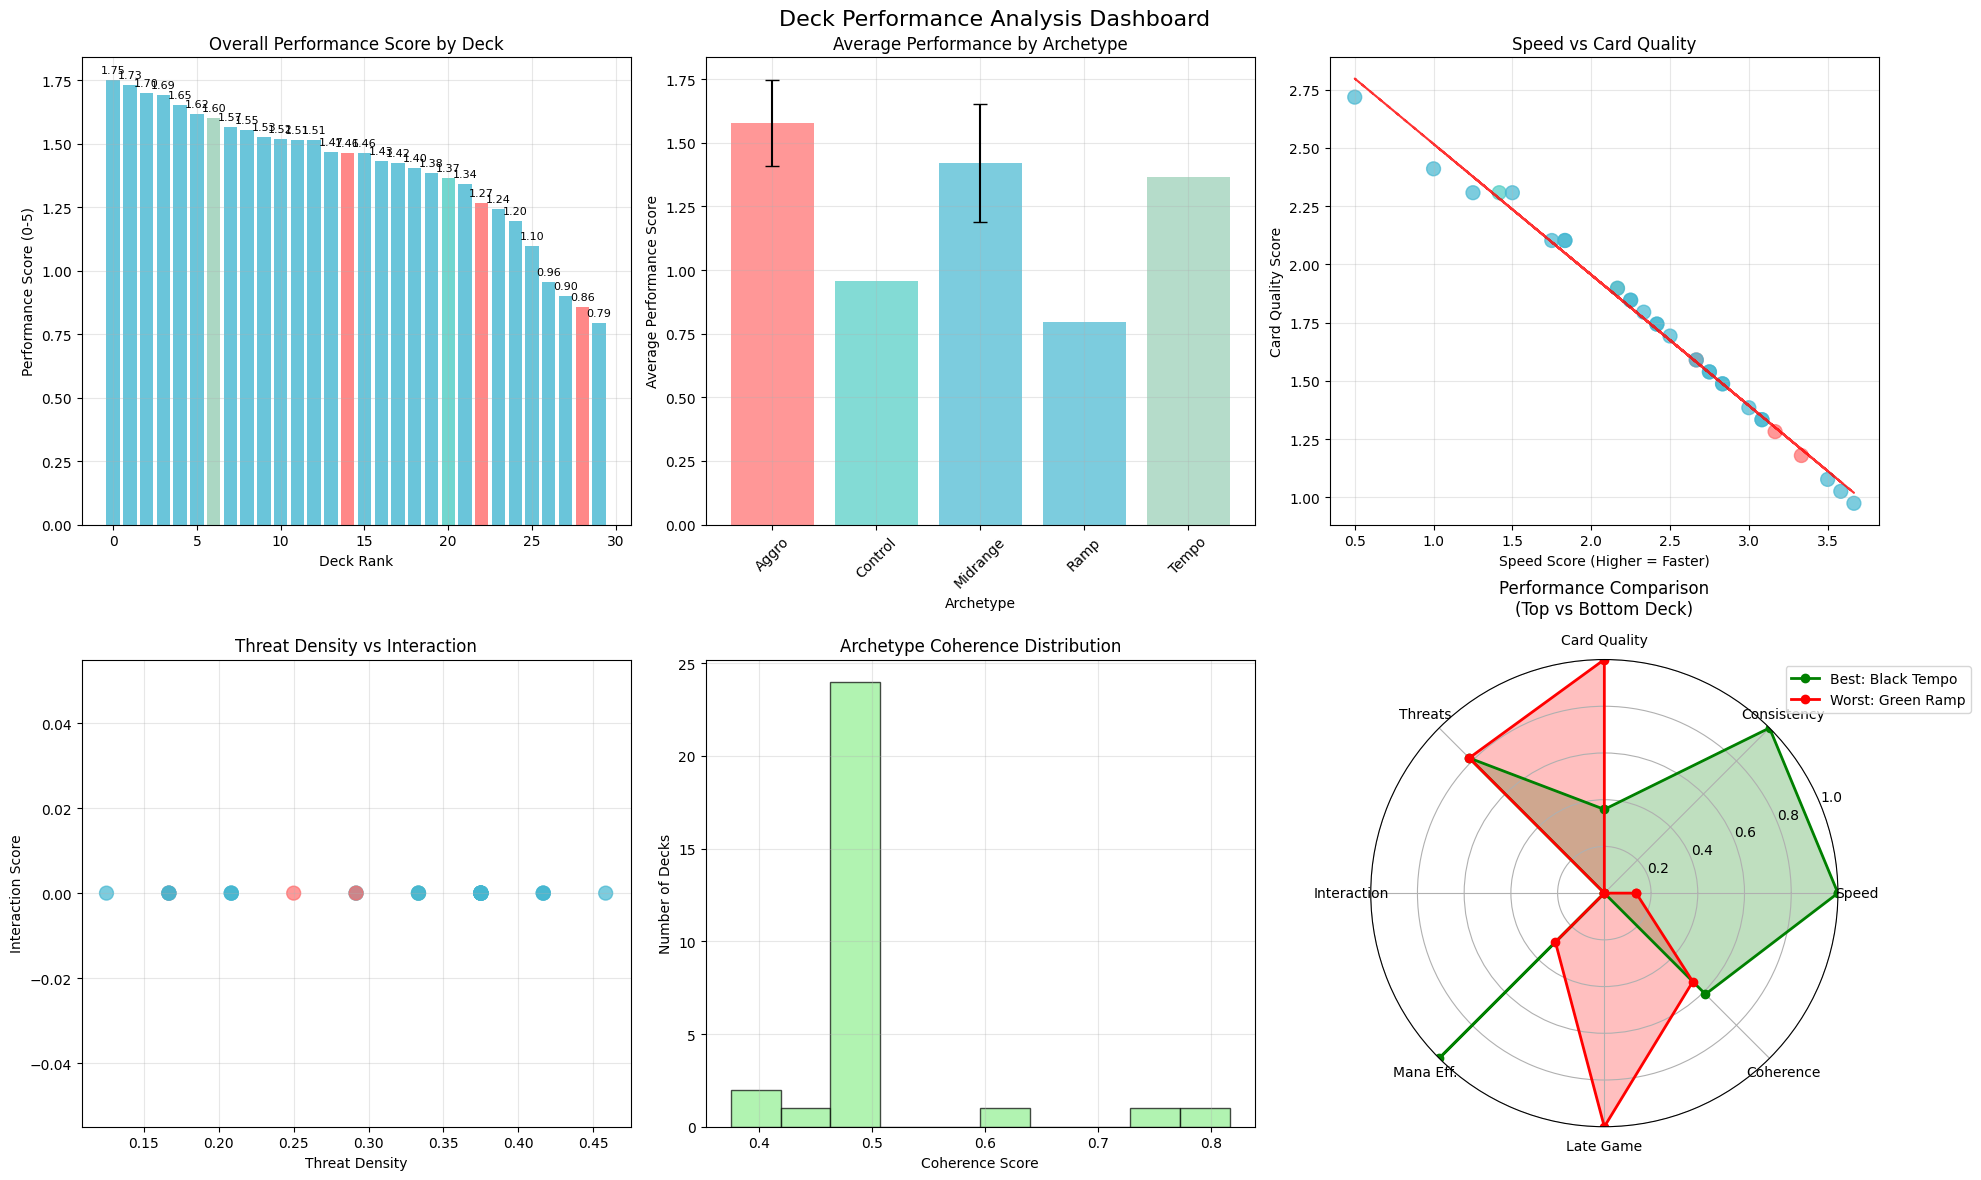

📊 Performance dashboard complete!
Best performing deck: Black Tempo (Score: 1.752)
Worst performing deck: Green Ramp (Score: 0.794)


In [17]:
# Create comprehensive performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Deck Performance Analysis Dashboard', fontsize=16, y=0.98)

# 1. Overall Performance Distribution
ax1 = axes[0, 0]
colors_by_archetype = [archetype_colors.get(arch, '#45B7D1') for arch in performance_df['archetype']]
bars = ax1.bar(range(len(performance_df)), performance_df['overall_performance'].sort_values(ascending=False),
               color=colors_by_archetype, alpha=0.8)
ax1.set_title('Overall Performance Score by Deck')
ax1.set_ylabel('Performance Score (0-5)')
ax1.set_xlabel('Deck Rank')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, performance_df['overall_performance'].sort_values(ascending=False))):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{score:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Performance by Archetype
ax2 = axes[0, 1]
archetype_performance = performance_df.groupby('archetype')['overall_performance'].agg(['mean', 'std', 'count'])
bars2 = ax2.bar(archetype_performance.index, archetype_performance['mean'], 
                yerr=archetype_performance['std'], capsize=5, alpha=0.7,
                color=[archetype_colors.get(arch, '#45B7D1') for arch in archetype_performance.index])
ax2.set_title('Average Performance by Archetype')
ax2.set_ylabel('Average Performance Score')
ax2.set_xlabel('Archetype')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.get_xticklabels(), rotation=45)

# 3. Speed vs Card Quality
ax3 = axes[0, 2]
scatter = ax3.scatter(performance_df['speed_score'], performance_df['card_quality'], 
                     c=colors_by_archetype, alpha=0.7, s=100)
ax3.set_title('Speed vs Card Quality')
ax3.set_xlabel('Speed Score (Higher = Faster)')
ax3.set_ylabel('Card Quality Score')
ax3.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(performance_df['speed_score'], performance_df['card_quality'], 1)
p = np.poly1d(z)
ax3.plot(performance_df['speed_score'], p(performance_df['speed_score']), "r--", alpha=0.8)

# 4. Threat Density vs Interaction
ax4 = axes[1, 0]
ax4.scatter(performance_df['threat_density'], performance_df['interaction_score'], 
           c=colors_by_archetype, alpha=0.7, s=100)
ax4.set_title('Threat Density vs Interaction')
ax4.set_xlabel('Threat Density')
ax4.set_ylabel('Interaction Score')
ax4.grid(True, alpha=0.3)

# 5. Archetype Coherence Distribution
ax5 = axes[1, 1]
ax5.hist(performance_df['archetype_coherence'], bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
ax5.set_title('Archetype Coherence Distribution')
ax5.set_xlabel('Coherence Score')
ax5.set_ylabel('Number of Decks')
ax5.grid(True, alpha=0.3)

# 6. Performance Radar Chart (Top 5 vs Bottom 5)
ax6 = axes[1, 2]
ax6.remove()  # Remove this subplot for the radar chart

# Create radar chart
from math import pi
categories = ['Speed', 'Consistency', 'Card Quality', 'Threats', 'Interaction', 'Mana Eff.', 'Late Game', 'Coherence']
metric_cols = ['speed_score', 'consistency_score', 'card_quality', 'threat_density', 
               'interaction_score', 'mana_efficiency', 'late_game_power', 'archetype_coherence']

# Normalize metrics to 0-1 scale for radar chart
normalized_df = performance_df[metric_cols].copy()
for col in metric_cols:
    max_val = normalized_df[col].max()
    if max_val > 0:
        normalized_df[col] = normalized_df[col] / max_val

# Get top and bottom performers
top_deck = performance_df.nlargest(1, 'overall_performance').index[0]
bottom_deck = performance_df.nsmallest(1, 'overall_performance').index[0]

# Create subplot for radar
ax6 = plt.subplot(2, 3, 6, projection='polar')
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# Plot top performer
top_values = normalized_df.loc[top_deck, metric_cols].values.tolist()
top_values += top_values[:1]
ax6.plot(angles, top_values, 'o-', linewidth=2, label=f'Best: {top_deck}', color='green')
ax6.fill(angles, top_values, alpha=0.25, color='green')

# Plot bottom performer
bottom_values = normalized_df.loc[bottom_deck, metric_cols].values.tolist()
bottom_values += bottom_values[:1]
ax6.plot(angles, bottom_values, 'o-', linewidth=2, label=f'Worst: {bottom_deck}', color='red')
ax6.fill(angles, bottom_values, alpha=0.25, color='red')

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim(0, 1)
ax6.set_title('Performance Comparison\n(Top vs Bottom Deck)', y=1.08)
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print("📊 Performance dashboard complete!")
print(f"Best performing deck: {top_deck} (Score: {performance_df.loc[top_deck, 'overall_performance']:.3f})")
print(f"Worst performing deck: {bottom_deck} (Score: {performance_df.loc[bottom_deck, 'overall_performance']:.3f})")

In [18]:
# Detailed Performance Analysis and Rankings
print("🏆 DETAILED PERFORMANCE RANKINGS")
print("="*60)

# Sort by overall performance
ranked_df = performance_df.sort_values('overall_performance', ascending=False)

print("TOP 10 PERFORMING DECKS:")
print("-" * 40)
for i, (theme, row) in enumerate(ranked_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {theme:<20} ({row['archetype']:<8}) - Score: {row['overall_performance']:.3f}")

print("\nBOTTOM 5 PERFORMING DECKS:")
print("-" * 40)
for i, (theme, row) in enumerate(ranked_df.tail(5).iterrows(), len(ranked_df)-4):
    print(f"{i:2d}. {theme:<20} ({row['archetype']:<8}) - Score: {row['overall_performance']:.3f}")

# Category leaders
print("\n🥇 CATEGORY LEADERS:")
print("-" * 40)
categories = {
    'Fastest Deck': 'speed_score',
    'Most Consistent': 'consistency_score', 
    'Highest Card Quality': 'card_quality',
    'Best Threat Density': 'threat_density',
    'Most Interactive': 'interaction_score',
    'Most Mana Efficient': 'mana_efficiency',
    'Best Late Game': 'late_game_power',
    'Most Coherent': 'archetype_coherence'
}

for category, metric in categories.items():
    leader = performance_df.nlargest(1, metric)
    theme = leader.index[0]
    score = leader[metric].iloc[0]
    archetype = leader['archetype'].iloc[0]
    print(f"{category:<20}: {theme} ({archetype}) - {score:.3f}")

print("\n📊 PERFORMANCE STATISTICS:")
print("-" * 40)
print(f"Average Performance Score: {performance_df['overall_performance'].mean():.3f}")
print(f"Performance Std Deviation: {performance_df['overall_performance'].std():.3f}")
print(f"Performance Range: {performance_df['overall_performance'].min():.3f} - {performance_df['overall_performance'].max():.3f}")

# Archetype analysis
print(f"\n🎯 ARCHETYPE PERFORMANCE:")
print("-" * 40)
archetype_stats = performance_df.groupby('archetype')['overall_performance'].agg(['mean', 'std', 'count'])
for archetype, stats in archetype_stats.iterrows():
    print(f"{archetype:<12}: Avg {stats['mean']:.3f} ± {stats['std']:.3f} ({stats['count']} decks)")

# Balance assessment
performance_range = performance_df['overall_performance'].max() - performance_df['overall_performance'].min()
print(f"\n⚖️ BALANCE ASSESSMENT:")
print("-" * 40)
if performance_range < 1.0:
    print("✅ EXCELLENT balance - decks are very evenly matched")
elif performance_range < 1.5:
    print("✅ GOOD balance - reasonable variation between decks")
elif performance_range < 2.0:
    print("⚠️  MODERATE balance - some decks significantly stronger")
else:
    print("❌ POOR balance - large performance gaps between decks")

print(f"Performance range: {performance_range:.3f}")
print(f"Coefficient of variation: {(performance_df['overall_performance'].std() / performance_df['overall_performance'].mean()):.3f}")

🏆 DETAILED PERFORMANCE RANKINGS
TOP 10 PERFORMING DECKS:
----------------------------------------
 1. Black Tempo          (Midrange) - Score: 1.752
 2. Red Aggro            (Midrange) - Score: 1.729
 3. Boros Aggro          (Aggro   ) - Score: 1.698
 4. Gruul Aggro          (Midrange) - Score: 1.691
 5. Rakdos Aggro         (Aggro   ) - Score: 1.653
 6. Orzhov Midrange      (Midrange) - Score: 1.616
 7. Red Tribals          (Midrange) - Score: 1.599
 8. Selesnya Midrange    (Midrange) - Score: 1.566
 9. Izzet Tempo          (Midrange) - Score: 1.553
10. Simic Ramp           (Midrange) - Score: 1.527

BOTTOM 5 PERFORMING DECKS:
----------------------------------------
26. Black Spellslinger   (Midrange) - Score: 1.097
27. Azorius Control      (Control ) - Score: 0.956
28. Dimir Control        (Midrange) - Score: 0.899
29. Blue Spellslinger    (Midrange) - Score: 0.856
30. Green Ramp           (Ramp    ) - Score: 0.794

🥇 CATEGORY LEADERS:
----------------------------------------
Fastes

In [19]:
def generate_improvement_suggestions(deck_name, metrics, deck_df):
    """Generate specific improvement suggestions for a deck based on its metrics."""
    suggestions = []
    
    # Speed improvements
    if metrics['speed_score'] < 2.5:
        avg_cmc = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]['CMC'].mean()
        suggestions.append(f"⚡ SPEED: Reduce average CMC from {avg_cmc:.1f} - add more 1-2 mana cards")
    
    # Consistency improvements  
    if metrics['consistency_score'] < 2.5:
        suggestions.append("🎯 CONSISTENCY: High CMC variance - smooth out the mana curve")
    
    # Card quality improvements
    if metrics['card_quality'] < 2.0:
        suggestions.append("⭐ QUALITY: Replace weakest cards with higher impact alternatives")
    
    # Threat density improvements
    if metrics['threat_density'] < 0.3:
        suggestions.append("👊 THREATS: Add more win conditions - need creatures with 3+ power or other threats")
    
    # Interaction improvements
    if metrics['interaction_score'] < 0.15:
        suggestions.append("🛡️ INTERACTION: Add removal spells, counterspells, or other answers")
    
    # Mana efficiency improvements
    if metrics['mana_efficiency'] < 1.0:
        suggestions.append("💎 EFFICIENCY: Cards are expensive for their effects - need better mana-to-impact ratio")
    
    # Late game improvements
    if metrics['late_game_power'] < 0.1 and metrics['archetype_coherence'] > 0.7:
        archetype = ALL_THEMES.get(deck_name, {}).get('archetype', 'Midrange')
        if archetype in ['Control', 'Midrange']:
            suggestions.append("🏰 LATE GAME: Add more expensive, powerful finishers")
    
    # Archetype coherence improvements
    if metrics['archetype_coherence'] < 0.5:
        archetype = ALL_THEMES.get(deck_name, {}).get('archetype', 'Midrange')
        if archetype == 'Aggro':
            suggestions.append("🏃 FOCUS: Deck should be faster and more aggressive for aggro archetype")
        elif archetype == 'Control':
            suggestions.append("🧠 FOCUS: Need more interaction and late-game power for control archetype")
        elif archetype == 'Combo':
            suggestions.append("⚙️ FOCUS: Improve consistency and mana efficiency for combo archetype")
        else:
            suggestions.append("🎯 FOCUS: Better align cards with the midrange/tempo strategy")
    
    return suggestions

# Analyze weakest performing decks and generate improvement suggestions
print("🔧 IMPROVEMENT SUGGESTIONS FOR WEAKEST DECKS")
print("="*60)

weakest_decks = ranked_df.tail(5)
for deck_name, metrics in weakest_decks.iterrows():
    print(f"\n📋 {deck_name.upper()} ({metrics['archetype']})")
    print(f"Current Score: {metrics['overall_performance']:.3f}")
    print("-" * 40)
    
    suggestions = generate_improvement_suggestions(deck_name, metrics, deck_dataframes[deck_name])
    
    if suggestions:
        for suggestion in suggestions:
            print(f"  {suggestion}")
    else:
        print("  ✅ Deck is performing well overall - minor tweaks may help")
    
    # Show current deck composition for context
    deck_df = deck_dataframes[deck_name]
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    creatures = deck_df[deck_df['Type'].str.contains('Creature', na=False)]
    
    print(f"  📊 Current Stats:")
    print(f"     - Avg CMC: {non_lands['CMC'].mean():.1f}")
    print(f"     - Creatures: {len(creatures)}/{len(non_lands)}")
    print(f"     - Early game (CMC ≤2): {len(non_lands[non_lands['CMC'] <= 2])}")

print(f"\n💡 GENERAL IMPROVEMENT STRATEGIES:")
print("-" * 40)
print("1. 🎯 Focus on archetype coherence - ensure cards support the deck's strategy")
print("2. ⚡ Balance mana curve - avoid too many expensive or cheap cards")
print("3. 👊 Include enough threats - minimum 30-40% of non-lands should pressure opponents") 
print("4. 🛡️ Add interaction - 15-25% removal/answers help deal with opposing threats")
print("5. ⭐ Prioritize card quality - powerful effects are worth slightly higher mana costs")
print("6. 🔄 Test synergies - cards that work together are more than sum of parts")

🔧 IMPROVEMENT SUGGESTIONS FOR WEAKEST DECKS

📋 BLACK SPELLSLINGER (Midrange)
Current Score: 1.097
----------------------------------------
  ⚡ SPEED: Reduce average CMC from 3.2 - add more 1-2 mana cards
  🎯 CONSISTENCY: High CMC variance - smooth out the mana curve
  🛡️ INTERACTION: Add removal spells, counterspells, or other answers
  💎 EFFICIENCY: Cards are expensive for their effects - need better mana-to-impact ratio
  📊 Current Stats:
     - Avg CMC: 3.2
     - Creatures: 8/12
     - Early game (CMC ≤2): 5

📋 AZORIUS CONTROL (Control)
Current Score: 0.956
----------------------------------------
  ⚡ SPEED: Reduce average CMC from 3.6 - add more 1-2 mana cards
  🎯 CONSISTENCY: High CMC variance - smooth out the mana curve
  👊 THREATS: Add more win conditions - need creatures with 3+ power or other threats
  🛡️ INTERACTION: Add removal spells, counterspells, or other answers
  💎 EFFICIENCY: Cards are expensive for their effects - need better mana-to-impact ratio
  🧠 FOCUS: Need mor

In [20]:
# Export performance analysis results
performance_export = performance_df.round(3)
performance_export.to_csv('output/deck_performance_analysis.csv')

# Create a summary report
summary_report = {
    'total_decks': len(performance_df),
    'avg_performance': performance_df['overall_performance'].mean(),
    'performance_std': performance_df['overall_performance'].std(),
    'best_deck': performance_df.nlargest(1, 'overall_performance').index[0],
    'worst_deck': performance_df.nsmallest(1, 'overall_performance').index[0],
    'most_balanced_archetype': archetype_stats.loc[archetype_stats['std'].idxmin()].name,
    'performance_range': performance_df['overall_performance'].max() - performance_df['overall_performance'].min()
}

print("📄 PERFORMANCE ANALYSIS EXPORT COMPLETE")
print("="*50)
print(f"✅ Detailed metrics saved to: deck_performance_analysis.csv")
print(f"✅ Analysis covers {summary_report['total_decks']} decks")
print(f"✅ Performance range: {summary_report['performance_range']:.3f}")
print(f"✅ Best deck: {summary_report['best_deck']}")
print(f"✅ Most balanced archetype: {summary_report['most_balanced_archetype']}")

# Show exportable data preview
print(f"\n📊 EXPORTABLE PERFORMANCE DATA PREVIEW:")
print("-" * 50)
preview_cols = ['archetype', 'overall_performance', 'speed_score', 'card_quality', 'threat_density', 'interaction_score']
print(performance_export[preview_cols].head(10))

📄 PERFORMANCE ANALYSIS EXPORT COMPLETE
✅ Detailed metrics saved to: deck_performance_analysis.csv
✅ Analysis covers 30 decks
✅ Performance range: 0.958
✅ Best deck: Black Tempo
✅ Most balanced archetype: Aggro

📊 EXPORTABLE PERFORMANCE DATA PREVIEW:
--------------------------------------------------
                   archetype  overall_performance  speed_score  card_quality  \
theme                                                                          
White Enchantments  Midrange                1.464        2.833         1.487   
White Slivers       Midrange                1.512        3.083         1.333   
White Tribals       Midrange                1.241        1.833         2.103   
White Voltron       Midrange                1.514        2.333         1.795   
Blue Tribals        Midrange                1.342        1.833         2.103   
Blue Mill           Midrange                1.431        3.083         1.333   
Blue Tempo             Tempo                1.366        2.

In [21]:
# Load the complete MTG card database for validation
import re
from collections import Counter, defaultdict
from jumpstart.src.theme_extraction.keywords import ALL_KEYWORD_SETS

print("🔄 Loading complete MTG card database...")
cards_df = pd.read_csv('.build/cards.csv')
print(f"✅ Loaded {len(cards_df)} cards for validation")

# Clean and prepare card data for analysis
cards_df['text'] = cards_df['text'].fillna('')  # Handle missing text
cards_df['text_lower'] = cards_df['text'].str.lower()
cards_df['type_lower'] = cards_df['type'].str.lower() 

print(f"Sample card data:")
print(f"  Total cards: {len(cards_df)}")
print(f"  Cards with text: {len(cards_df[cards_df['text'] != ''])}")
print(f"  Unique card types: {cards_df['type'].nunique()}")

# Show some examples
print(f"\nExample cards:")
sample_cards = cards_df[cards_df['text'] != ''].head(3)
for _, card in sample_cards.iterrows():
    print(f"  {card['name']}: {card['text'][:100]}...")

🔄 Loading complete MTG card database...
✅ Loaded 32383 cards for validation
Sample card data:
  Total cards: 32383
  Cards with text: 32037
  Unique card types: 3650

Example cards:
  And They Shall Know No Fear: Choose a creature type. Creatures you control of the chosen type get +1/+0 and gain indestructible u...
  Celestine, the Living Saint: Flying, lifelink\nHealing Tears — At the beginning of your end step, return target creature card wit...
  Defenders of Humanity: When this enchantment enters, create X 2/2 white Astartes Warrior creature tokens with vigilance.\n{...
